In [1]:
#-------------------------------------------------------
#  BIBLIOTECAS
#-------------------------------------------------------
import pandas as pd
import warnings
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics 
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from datetime import datetime

warnings.filterwarnings("ignore", category=DeprecationWarning)

#-------------------------------------------------------
#  BASES
#-------------------------------------------------------

colsbd = ['CTA','FISJUR','DTNASCDTFUND','SEXO','NDEP','ESTCIV','CATPRO','RCLI','DTABCTA','BLCTAMF']
colsci = ['CTA','CTO','CDTPCTO','PRODUTO','NPARC','SLENC','FX_ATRASO2_MAX',]

try:
    bd202101 = pd.read_csv(r'C:\Users\PC Vinicius\Documents\Produção Meus Documentos\PEP 3\BD202101.csv', sep=';', decimal=',', usecols=colsbd)
except:
    try:
        bd202101 = pd.read_csv(r'C:\Users\Notebook Vinicius\Documents\Produção Meus Documentos\PEP 3\BD202101.csv', sep=';', decimal=',', usecols=colsbd)
    except:
        bd202101 = pd.read_csv(r'C:\Users\980\Documents\Produção\BD202101.csv', sep=';', decimal=',', usecols=colsbd)

try:
    ci202107 = pd.read_csv(r'C:\Users\PC Vinicius\Documents\Produção Meus Documentos\PEP 3\CI202107.csv', sep=';', decimal=',', usecols=colsci)
except:
    try:
        ci202107 = pd.read_csv(r'C:\Users\Notebook Vinicius\Documents\Produção Meus Documentos\PEP 3\CI202107.csv', sep=';', decimal=',', usecols=colsci)
    except:
        ci202107 = pd.read_csv(r'C:\Users\980\Documents\Produção\CI202107.csv', sep=';', decimal=',', usecols=colsci)


In [2]:
bd = bd202101
bd = bd[bd['FISJUR']=='F']
bd = bd[bd['DTABCTA'].notna()]
bd = bd[bd['BLCTAMF']!=1]


#Trasnformar em datetime
bd['DATA_NASC']=pd.to_datetime(bd['DTNASCDTFUND'],format="%Y/%m/%d")

#Aplicar função para calcular idade

from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

bd['IDADE']=bd['DATA_NASC'].apply(calculate_age)
bd.drop('FISJUR', axis=1, inplace=True)
bd.drop('DTABCTA', axis=1, inplace=True)
bd.drop('BLCTAMF', axis=1, inplace=True)
bd.drop('DATA_NASC', axis=1, inplace=True)
bd.drop('DTNASCDTFUND', axis=1, inplace=True)

bd

,CTA,SEXO,NDEP,ESTCIV,CATPRO,RCLI,IDADE
0,3.0,F,1.0,CA,AUTÔNOMO,2500.0,71.0
2,5.0,M,1.0,CA,ASSALARIADO,1500.0,57.0
3,6.0,F,0.0,CA,APOSENTADO,520.0,92.0
4,7.0,M,0.0,CA,AGRICULTOR,300.0,57.0
5,8.0,F,1.0,CA,LIBERAL,800.0,53.0
...,...,...,...,...,...,...,...
5631316,16931242.0,F,0.0,SO,ASSALARIADO,1200.0,20.0
5631319,16931245.0,F,NaN,SO,ASSALARIADO,1800.0,44.0
5631326,16931252.0,M,NaN,CA,ASSALARIADO,1800.0,33.0
5631344,16931270.0,M,NaN,SO,AUTÔNOMO,1800.0,27.0


In [3]:
ci = ci202107.copy()

#ci['CDTPCTO'] = np.where((ci['CDTPCTO']=='EC') & ((ci['CDMOD']==15) | (ci['CDMOD']==20)),'RN',ci['CDTPCTO'])

ci['CDTPCTO'] = np.where(ci['CDTPCTO']=='EB','CL',ci['CDTPCTO'])
ci['CDTPCTO'] = np.where(ci['CDTPCTO']=='CC','CL',ci['CDTPCTO'])
#ci['CDTPCTO'] = np.where(ci['CDTPCTO']=='CL','CS',ci['CDTPCTO'])

ci['PRODUTO'] = np.where(ci['PRODUTO']=='RENEGOC_02','RENEGOC',ci['PRODUTO'])
ci['PRODUTO'] = np.where(ci['PRODUTO']=='PARC_FAT','RENEGOC',ci['PRODUTO'])
ci['PRODUTO'] = np.where(ci['CDTPCTO']=='CS','FINANC',ci['PRODUTO'])
ci['PRODUTO'] = np.where(ci['PRODUTO']=='S_JUROS','COMPRA',ci['PRODUTO'])
ci['PRODUTO'] = np.where(ci['PRODUTO']=='C_JUROS','COMPRA',ci['PRODUTO'])
#ci['PRODUTO'] = np.where(ci['PRODUTO']=='EMPRESTIMO','FINANC',ci['PRODUTO'])
#Estudar remover Empréstimo

cdtpcto = ['CS','EB','CC','CD','CL','EP','CJ','EC','RN','PF']

produtos = ['S_JUROS','C_JUROS','EMPRESTIMO']

ci = ci[ci['CDTPCTO'].isin(cdtpcto)]

ci.drop('CDTPCTO', axis=1, inplace=True)

#ci['CDTPCTO'].value_counts()
ci#['PRODUTO'].value_counts()
#ci[ci['CDTPCTO']=='PF']['PRODUTO'].value_counts()

,CTA,CTO,PRODUTO,NPARC,SLENC,FX_ATRASO2_MAX
0,10.0,1.002032e+11,COMPRA,13.0,29.75,Em dia
2,15.0,1.002278e+11,COMPRA,12.0,7500.00,Em dia
3,23.0,1.002179e+11,COMPRA,10.0,1599.20,Em dia
4,23.0,1.002254e+11,COMPRA,1.0,100.00,Em dia
5,23.0,1.002258e+11,RENEGOC,4.0,666.33,Em dia
...,...,...,...,...,...,...
5200528,77631321.0,1.002281e+11,COMPRA,10.0,2234.46,Em dia
5200529,77631347.0,1.002281e+11,COMPRA,4.0,713.25,Em dia
5200530,77631376.0,1.002281e+11,COMPRA,1.0,19.50,Em dia
5200531,77631376.0,1.002281e+11,COMPRA,1.0,28.00,Em dia


In [4]:
####### MERGE E FILTROS

df = pd.merge(bd,ci,how='left',on='CTA')

df = df[df['FX_ATRASO2_MAX'].notna()]
df = df[df['SEXO'].notna()]


df['CATPRO'].fillna('AUTÔNOMO', inplace = True)
df['NDEP'] = df['NDEP'].fillna(0)
df['ESTCIV'] = df['ESTCIV'].fillna('SO')
df['RCLI'] = df['RCLI'].fillna(2000)
df['IDADE'] = df['IDADE'].fillna(45)

df['ESTCIV'] = np.where(df['ESTCIV']=='CO','CA',df['ESTCIV'])

In [5]:
menos_1ano = ['1 a 14','15 a 30','31 a 60','61 a 90', '91 a 120', '121 a 150','151 a 180','181 a 210',
              '211 a 240','241 a 270','271 a 300','301 a 330','331 a 360'] 
mais_1ano = ['361 a 390','Maior 390']

df['ATRASO'] = np.where(df['FX_ATRASO2_MAX']=='Em dia', 'Em dia',
                        np.where(df['FX_ATRASO2_MAX'].isin(mais_1ano), 'Mais de 1 ano', 'Menos de 1 ano'))

df['ATRASO'].value_counts()
df.drop('FX_ATRASO2_MAX',axis=1, inplace=True)

df['CLASSE'] = np.where(df['ATRASO']=='Em dia', 0, 1)

In [6]:
df

,CTA,SEXO,NDEP,ESTCIV,CATPRO,RCLI,IDADE,CTO,PRODUTO,NPARC,SLENC,ATRASO,CLASSE
5,10.0,M,0.0,CA,APOSENTADO,724.0,27.0,1.002032e+11,COMPRA,13.0,29.75,Em dia,0
9,15.0,M,0.0,CA,APOSENTADO,2000.0,71.0,1.002278e+11,COMPRA,12.0,7500.00,Em dia,0
16,23.0,M,0.0,CA,ASSALARIADO,633.1,47.0,1.002179e+11,COMPRA,10.0,1599.20,Em dia,0
17,23.0,M,0.0,CA,ASSALARIADO,633.1,47.0,1.002254e+11,COMPRA,1.0,100.00,Em dia,0
18,23.0,M,0.0,CA,ASSALARIADO,633.1,47.0,1.002258e+11,RENEGOC,4.0,666.33,Em dia,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7201589,16931227.0,M,0.0,CA,AUTÔNOMO,3500.0,45.0,1.002097e+11,COMPRA,3.0,1044.92,Menos de 1 ano,1
7201590,16931227.0,M,0.0,CA,AUTÔNOMO,3500.0,45.0,1.002100e+11,EMPRESTIMO,10.0,6199.82,Menos de 1 ano,1
7201591,16931238.0,M,0.0,SO,AUTÔNOMO,6750.0,37.0,1.002098e+11,COMPRA,10.0,259.42,Em dia,0
7201592,16931238.0,M,0.0,SO,AUTÔNOMO,6750.0,37.0,1.002175e+11,COMPRA,12.0,3110.00,Em dia,0


In [7]:
df['ESTCIV'].value_counts()

CA    2137960
SO    2020063
SE     333142
VI     264411
Name: ESTCIV, dtype: int64

In [8]:
df['PRODUTO'].value_counts()

COMPRA        2931421
FINANC        1504944
RENEGOC        192392
EMPRESTIMO     126819
Name: PRODUTO, dtype: int64

In [9]:
group = df.groupby('CLASSE').count().reset_index()[['CTO','CLASSE']]
group['Percentual'] = 100*group['CTO']/group['CTO'].sum()
group

,CTO,CLASSE,Percentual
0,1634398,0,34.368034
1,3121178,1,65.631966


In [10]:
df.groupby('CTA').count().reset_index()[['CTA','CTO']]

,CTA,CTO
0,10.0,1
1,15.0,1
2,23.0,5
3,28.0,1
4,30.0,1
...,...,...
904378,16931212.0,3
904379,16931213.0,1
904380,16931216.0,2
904381,16931227.0,2


In [11]:
df[df['ATRASO']!='Em dia']['SLENC'].sum()

df_backup = df.copy()

In [12]:
#-------------------------------------------------------
#  CRIAÇÃO DE DUMMIES
#-------------------------------------------------------
df = df_backup.copy()

df.drop('CTA', axis=1, inplace=True)
df.drop('CTO', axis=1, inplace=True)
df.drop('ATRASO', axis=1, inplace=True)

df = pd.get_dummies(df)

In [13]:
sample_20k = df.sample(n=20000)
sample_5k = sample_20k.sample(n=5000)

#sample_10k.describe()

In [15]:
#Ler a base 10k

try:
    df = pd.read_excel(r'C:\Users\PC Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\sample_5k.xlsx')
except:
    try:
        df = pd.read_excel(r'C:\Users\Notebook Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\sample_5k.xlsx')
    except:
        df = pd.read_excel(r'C:\Users\980\Documents\My Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\sample_5k.xlsx')

In [16]:
df.describe()

,NDEP,RCLI,IDADE,NPARC,SLENC,CLASSE,SEXO_F,SEXO_M,ESTCIV_CA,ESTCIV_SE,...,ESTCIV_VI,CATPRO_AGRICULTOR,CATPRO_APOSENTADO,CATPRO_ASSALARIADO,CATPRO_AUTÔNOMO,CATPRO_LIBERAL,PRODUTO_COMPRA,PRODUTO_EMPRESTIMO,PRODUTO_FINANC,PRODUTO_RENEGOC
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.426200,1459.163158,47.933600,3.478600,294.815516,0.659200,0.492200,0.507800,0.43880,0.073600,...,0.057800,0.022600,0.191800,0.518400,0.265000,0.002200,0.614600,0.023400,0.324200,0.037800
std,0.810608,1148.911330,15.274733,4.971206,923.311747,0.474026,0.499989,0.499989,0.49629,0.261145,...,0.233388,0.148639,0.393756,0.499711,0.441377,0.046857,0.486738,0.151185,0.468122,0.190731
min,0.000000,0.000000,21.000000,1.000000,0.540000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,804.750000,36.000000,1.000000,31.587500,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1200.000000,46.000000,1.000000,72.000000,1.000000,0.000000,1.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1800.000000,59.000000,3.000000,190.612500,1.000000,1.000000,1.000000,1.00000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,10.000000,30000.000000,101.000000,36.000000,33415.290000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


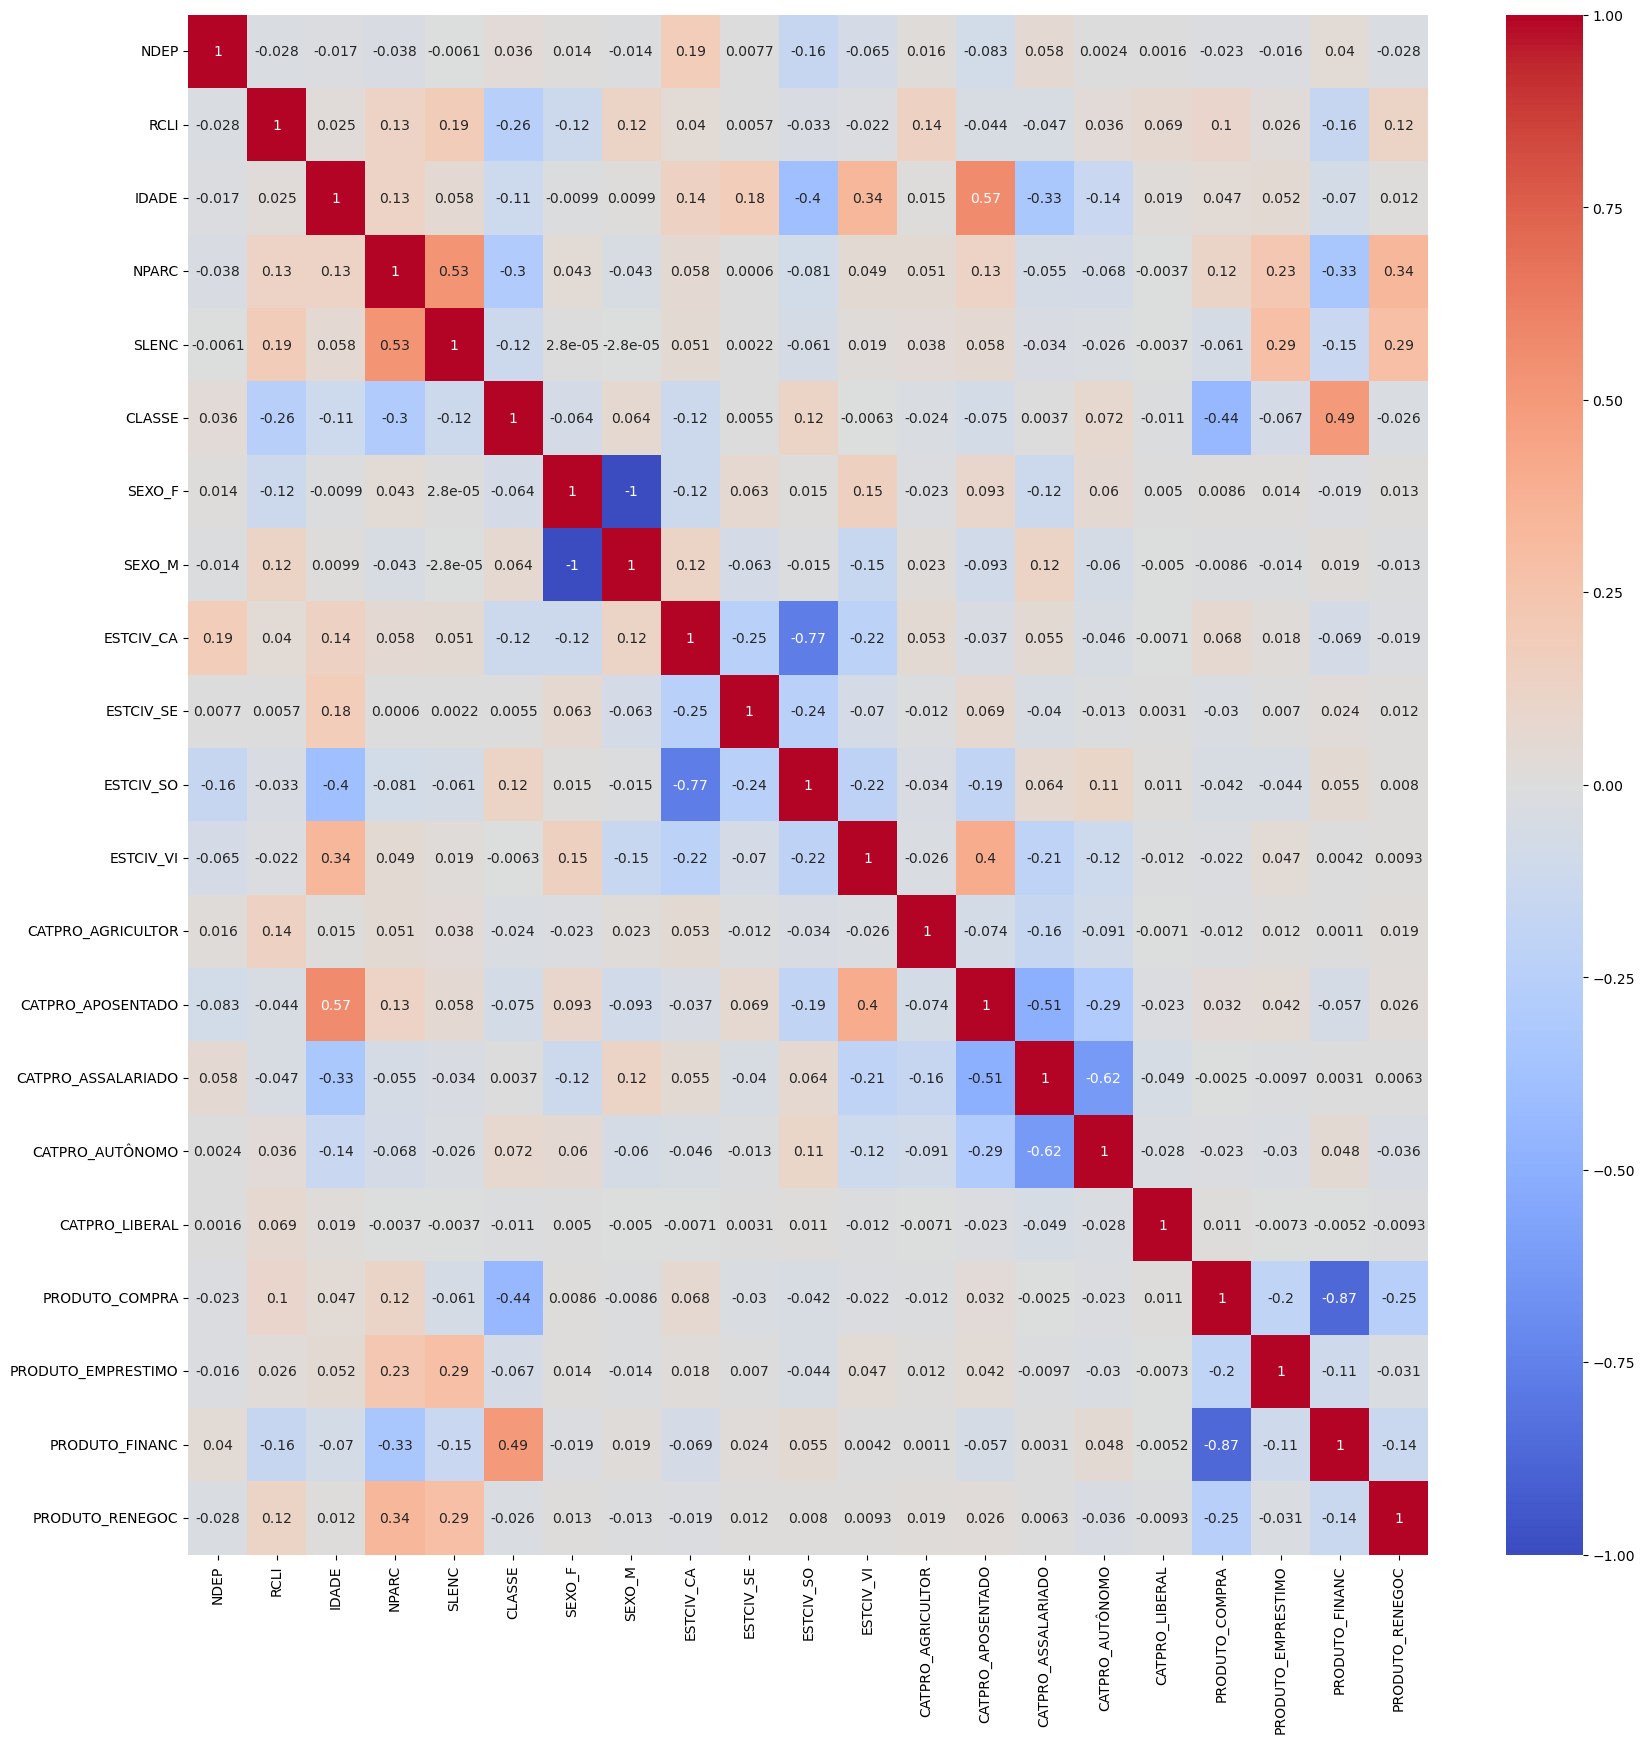

In [18]:
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Heatmap')
plt.show()


1    13200
0     6800
Name: CLASSE, dtype: int64


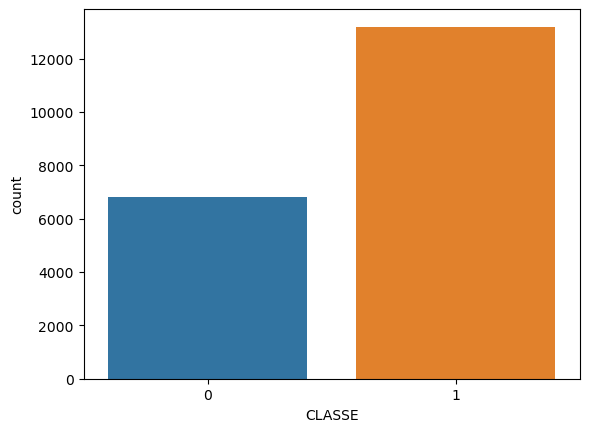

In [29]:
#-------------------------------------------------------
#  LEITURA DOS DADOS
#---------------------------------------------------------

print(df.CLASSE.value_counts())

ax = sns.countplot(x="CLASSE", data=df)

y = df['CLASSE'].reset_index()
y.drop('index', axis = 1, inplace = True)
y = y['CLASSE']

col = df.drop('CLASSE', axis = 1).reset_index()
col.drop('index', axis = 1, inplace = True)

In [30]:
#---------------------------------------------------------
#  NORMALIZAÇÃO (0,1)
#---------------------------------------------------------
def normaliz(x):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    x = min_max_scaler.fit_transform(x)
    return x

In [31]:
#---------------------------------------------------------
#  BALANCEAMENTO DA BASE UTILIZANDO A TÉCNICA 
#---------------------------------------------------------,
#from imblearn.under_sampling import InstanceHardnessThreshold
#from imblearn.under_sampling import NearMiss 

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import InstanceHardnessThreshold

#def balanceamento(xdesbalanceado, ydesbalanceado):
#    iht = InstanceHardnessThreshold()
#    Xx, Yy = iht.fit_resample(xdesbalanceado, ydesbalanceado)
#    np.bincount(Yy)
    
    #ax = sns.countplot(x=Yy)
#    print(np.bincount(Yy))
#    return Xx, Yy

In [32]:
def balanceamento(xdesbalanceado, ydesbalanceado):
    algoritmo = SMOTE()
    Xx, Yy = algoritmo.fit_resample(xdesbalanceado, ydesbalanceado)
    np.bincount(Yy)
    
    print(np.bincount(Yy))
    return Xx, Yy

In [33]:
#---------------------------------------------------------
#  MEDIDAS DE DESEMPENHO
#---------------------------------------------------------
#Primeiro eu quero que apareça os tn = true negative; fp = false positive; fn = false negative; tp = true positive
def TrueFalseNegPos(yteste, y_predtest):
    tnntest, fpntest, fnntest, tpntest = sklearn.metrics.confusion_matrix(yteste, y_predtest, normalize='all').ravel()
    return tnntest, fpntest, fnntest, tpntest
#Segundo eu quero que apareça uma acurácia (%) geral do modelo, estimativa de quantos dados foram classificados 
def acuracy(yteste, y_predtest):
    Acuraciatest = sklearn.metrics.accuracy_score(yteste, y_predtest)
    return Acuraciatest
#Terceiro eu quero que apareça o ValorPreditivoNegativo (VPN) = (tn / (tn + fn))
def ValorPreditivoNegativo(tnntest, fnntest):
    VPNtest = (tnntest/(tnntest + fnntest)) 
    return VPNtest
#Quarto eu quero que apareça a precisão/ValorPreditivoPositivo (VPP) do modelo = (tp / (tp + fp))
def precisaoVPP(yteste, y_predtest):
    precisãotest = sklearn.metrics.precision_score(yteste, y_predtest)
    return precisãotest
#Quinto eu quero que apareça o recall/ou revocação/ou sensibilidade do modelo = (tp / (tp + fn))
def recallSensibilidade(yteste, y_predtest):
    recalltest = sklearn.metrics.recall_score(yteste, y_predtest)
    return recalltest
#Sexto eu quero que apareça o F1-score do modelo = 2*(precisão*recall)/(precisão+recall)
def fscore(yteste, y_predtest):
    F1scoretest = sklearn.metrics.f1_score(yteste, y_predtest)
    return F1scoretest
#Sétimo, está faltando aparecer a especificidade do modelo, não encontrei uma função dentro da biblioteca que faça isso
#O calculo da especificidade do modelo é = (tn / (tn+fp))
def especificidade(tnntest, fpntest):
    esptest = (tnntest/(tnntest + fpntest))
    return esptest
#Oitavo, eu quero que apareca a area sobre a curva da curva ROC
def AUCcurvaROC(yteste, y_predtest):
    AUCtest = sklearn.metrics.roc_auc_score(yteste, y_predtest) 
    return AUCtest

In [34]:
x = normaliz(col)
#x = pd.DataFrame(x)
x
x[2]
#xcalibra, ycalibra = balanceamento(x, y)
#xcal = MutualInf(xcalibra, ycalibra, col)

array([0.        , 0.02226703, 0.40196078, 0.48571429, 0.58818919,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ])

In [35]:
C = [5,10,15,25,50,100]
for n in C:
    gamma = ['scale', 'auto', 0.01, 1, 10]
    for g in gamma:
        kernel = ['rbf','sigmoid']
        for i in kernel:
            
            kfeature = []
            #APPEND TESTA 100 resultados
            Accgeraltest = []
            vpngeraltest = []
            Precgeraltest = []
            Recgeraltest = []
            Fscoregeraltest = []
            especgeraltest = []
            aucgeraltest = []
            #APPEND VALIDA 100 resultados
            Accgeralval = []
            vpngeralval = []
            Precgeralval = []
            Recgeralval = []
            Fscoregeralval = []
            especgeralval = []
            aucgeralval = []
            
            
            
            
            
            
            skf = StratifiedKFold(n_splits=10)
            skf.get_n_splits(x, y)
            for cal_index, tesval_index in skf.split(x, y):
                #print("CALIBRA:", train_index, "VALIDA:", test_index)
                xcalibra, xtesval = x[cal_index], x[tesval_index]
                ycalibra, ytesval = y[cal_index], y[tesval_index]
        
                xcalibra = pd.DataFrame(xcalibra)      
                xcalibra.columns = col.columns
        
                xtesval = pd.DataFrame(xtesval)  
                xtesval.columns = col.columns
            
            

                kfeaturea = []
                #APPEND TESTA
                tntest = []
                fptest = []
                fntest = []
                tptest = []
                Acctest = []
                vpntest = []
                Prectest = []
                Rectest = []
                Fscoretest = []
                espectest = []
                auctest = []
                #APPEND VALIDA
                tnval = []
                fpval = []
                fnval = []
                tpval = []
                Accval = []
                vpnval = []
                Precval = []
                Recval = []
                Fscoreval = []
                especval = []
                aucval = []
        
        
        
        
        
        
                
                #divisão da base de dados em validação e teste
                skf = StratifiedKFold(n_splits=10)
                skf.get_n_splits(xtesval, ytesval)
                for test_index, val_index in skf.split(xtesval, ytesval):
                    #print("TRAIN:", train_index, "TEST:", test_index)
                    print('____________________________________________________________________________')
                    print('Atualmente temos parâmetros K=', n, ', gamma=', g, ', kernel=', i)
                    print("Current time:", datetime.now())
                    xtesta, xvalida = xtesval.iloc[test_index], xtesval.iloc[val_index]
                    ytesta, yvalida = ytesval.iloc[test_index], ytesval.iloc[val_index]
            
            
                    xtreina, ytreina = balanceamento(xcalibra, ycalibra)
                    xtesta, ytesta = balanceamento(xtesta, ytesta)
        
        
        




                    model = model = RandomForestClassifier(n_estimators=n, random_state=101)
                    sfs1 = SFS(model, k_features=(1, 20), forward=True, floating=False, scoring='f1', cv=0, n_jobs=-1) #n_jobs=-1
                    feature_names = col.columns
                    #sfs1 = sfs1.fit(xtreina, ytreina, custom_feature_names=feature_names)
                    sfs1 = sfs1.fit(xtreina, ytreina)


                    sfsfeature = sfs1.k_feature_idx_
                    variaveisUteis = sfs1.k_feature_names_

                    X_train_sfs = sfs1.transform(xtreina)
                    X_test_sfs = sfs1.transform(xtesta)
                    X_val_sfs = sfs1.transform(xvalida)

                    model.fit(X_train_sfs, ytreina)

                    y_predtest = model.predict(X_test_sfs)  
                    y_predval = model.predict(X_val_sfs) 
                    

                    # y_predtest
                    tnntest, fpntest, fnntest, tpntest = TrueFalseNegPos(ytesta, y_predtest)
                    Acuraciatest = acuracy(ytesta, y_predtest)
                    VPNtest = ValorPreditivoNegativo(tnntest, fnntest)
                    precisãotest = precisaoVPP(ytesta, y_predtest)
                    recalltest = recallSensibilidade(ytesta, y_predtest)
                    F1scoretest = fscore(ytesta, y_predtest)
                    esptest = especificidade(tnntest, fpntest)
                    AUCtest = AUCcurvaROC(ytesta, y_predtest)
                    #print('Acuraciatest =', Acuraciatest, 'VPNtest =', VPNtest, 'precisãotest =', precisãotest, 'recalltest=', recalltest, 'F1scoretest =', F1scoretest, 'esptest=', esptest, 'AUCtest=', AUCtest)

                    # y_predval
                    tnnval, fpnval, fnnval, tpnval = TrueFalseNegPos(yvalida, y_predval)
                    Acuraciaval = acuracy(yvalida, y_predval)
                    VPNval = ValorPreditivoNegativo(tnnval, fnnval)
                    precisãoval = precisaoVPP(yvalida, y_predval)
                    recallval = recallSensibilidade(yvalida, y_predval)
                    F1scoreval = fscore(yvalida, y_predval)
                    espval = especificidade(tnnval, fpnval)
                    AUCval = AUCcurvaROC(yvalida, y_predval)
                    #print('Acuraciaval =', Acuraciaval, 'VPNval =', VPNval, 'precisãoval =', precisãoval, 'recallval=', recallval, 'F1scoreval =', F1scoreval, 'espval=', espval, 'AUCval=', AUCval)

                    kfeaturea.extend(variaveisUteis)
                    #APPEND TESTA
                    tntest.append(tnntest)
                    fptest.append(fpntest)
                    fntest.append(fnntest)
                    tptest.append(tpntest)
                    Acctest.append(Acuraciatest)
                    Prectest.append(precisãotest)
                    Rectest.append(recalltest)
                    Fscoretest.append(F1scoretest)
                    espectest.append(esptest)
                    auctest.append(AUCtest)
                    vpntest.append(VPNtest)
                    #APPEND TESTA
                    tnval.append(tnnval)
                    fpval.append(fpnval)
                    fnval.append(fnnval)
                    tpval.append(tpnval)
                    Accval.append(Acuraciaval)
                    Precval.append(precisãoval)
                    Recval.append(recallval)
                    Fscoreval.append(F1scoreval)
                    especval.append(espval)
                    aucval.append(AUCval)
                    vpnval.append(VPNval)

                kfeature.extend(kfeaturea)
                #APPEND TESTA 100 resultados
                Accgeraltest.append(Acctest)
                vpngeraltest.append(vpntest)
                Precgeraltest.append(Prectest)
                Recgeraltest.append(Rectest)
                Fscoregeraltest.append(Fscoretest)
                especgeraltest.append(espectest)
                aucgeraltest.append(auctest)
                #APPEND VALIDA 100 resultados
                Accgeralval.append(Accval)
                vpngeralval.append(vpnval)
                Precgeralval.append(Precval)
                Recgeralval.append(Recval)
                Fscoregeralval.append(Fscoreval)
                especgeralval.append(especval)
                aucgeralval.append(aucval)
                print()
                print('____⇈____Acima estão os resultados dos 10folds de teste____⇈____')
                print()

            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('____⇊____Abaixo estão os resultados dos 10folds de validação x (10 folds de teste)____⇊____')
            print('TESTE - Média acurácia =', np.mean(Accgeraltest))
            print('TESTE - Desvpad acurácia =', np.std(Accgeraltest))
            print()
            print('VALIDAÇÃO - Média acurácia =', np.mean(Accgeralval))
            print('VALIDAÇÃO - Desvpad acurácia =', np.std(Accgeralval))
            print('---')
            print('TESTE - Média VPN =', np.mean(vpngeraltest))
            print('TESTE - Desvpad VPN =', np.std(vpngeraltest))
            print()
            print('VALIDAÇÃO - Média VPN =', np.mean(vpngeralval))
            print('VALIDAÇÃO - Desvpad VPN =', np.std(vpngeralval))
            print('---')
            print('TESTE - Média precisão =', np.mean(Precgeraltest))
            print('TESTE - Desvpad precisão =', np.std(Precgeraltest))
            print()
            print('VALIDAÇÃO - Média precisão =', np.mean(Precgeralval))
            print('VALIDAÇÃO - Desvpad precisão =', np.std(Precgeralval))
            print('---')
            print('TESTE - Média recall =', np.mean(Recgeraltest))
            print('TESTE - Desvpad recall =', np.std(Recgeraltest))
            print()
            print('VALIDAÇÃO - Média recall =', np.mean(Recgeralval))
            print('VALIDAÇÃO - Desvpad recall =', np.std(Recgeralval))
            print('---')
            print('TESTE - Média f1score =', np.mean(Fscoregeraltest))
            print('TESTE - Desvpad f1score =', np.std(Fscoregeraltest))
            print()
            print('VALIDAÇÃO - Média f1score =', np.mean(Fscoregeralval))
            print('VALIDAÇÃO - Desvpad f1score =', np.std(Fscoregeralval))
            print('---')
            print('TESTE - Média especificidade =', np.mean(especgeraltest))
            print('TESTE - Desvpad especificidade =', np.std(especgeraltest))
            print()
            print('VALIDAÇÃO - Média especificidade =', np.mean(especgeralval))
            print('VALIDAÇÃO - Desvpad especificidade =', np.std(especgeralval))
            print('---')
            print('TESTE - Média AUC =', np.mean(aucgeraltest))
            print('TESTE - Desvpad AUC =', np.std(aucgeraltest))
            print()
            print('VALIDAÇÃO - Média AUC =', np.mean(aucgeralval))
            print('VALIDAÇÃO - Desvpad AUC =', np.std(aucgeralval))
            print('---')
            print('---')
            print('Vetor Acurácia TESTE 10x10 fold =', Accgeraltest)
            print('Vetor Acurácia VALIDAÇÃO 10x10 fold =', Accgeralval)
            print('Vetor VPN TESTE 10x10 fold =', vpngeraltest)
            print('Vetor VPN VALIDAÇÃO 10x10 fold =', vpngeralval)
            print('Vetor precisão TESTE 10x10 fold =', Precgeraltest)
            print('Vetor precisão VALIDAÇÃO 10x10 fold =', Precgeralval)
            print('Vetor recall TESTE 10x10 fold =', Recgeraltest)
            print('Vetor recall VALIDAÇÃO 10x10 fold =', Recgeralval)
            print('Vetor f1score TESTE 10x10 fold =', Fscoregeraltest)
            print('Vetor f1score VALIDAÇÃO 10x10 fold =', Fscoregeralval)
            print('Vetor especificidade TESTE 10x10 fold =', especgeraltest)
            print('Vetor especificidade VALIDAÇÃO 10x10 fold =', especgeralval)
            print('Vetor AUC TESTE 10x10 fold =', aucgeraltest)
            print('Vetor AUC VALIDAÇÃO 10x10 fold =', aucgeralval)
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            print('variáveis retidas em todas as iterações=')
            a = kfeature
            #print(a)
            b = {x:a.count(x) for x in a}
            #print(b)
            c, d = b.keys(), b.values()
            print(c)
            print(d)
            print()
            
            import pandas as pd
            import numpy as np
            # Create an empty DataFrame
            results = pd.DataFrame(columns=["VARIÁVEL", "VALOR"])
            # Define the variables and their corresponding values
            variables = [("TESTE - Média acurácia", np.mean(Accgeraltest)),
                         ("TESTE - Desvpad acurácia", np.std(Accgeraltest)),
                         ("VALIDAÇÃO - Média acurácia", np.mean(Accgeralval)),
                         ("VALIDAÇÃO - Desvpad acurácia", np.std(Accgeralval)),
                         ("TESTE - Média VPN", np.mean(vpngeraltest)),
                         ("TESTE - Desvpad VPN", np.std(vpngeraltest)),
                         ("VALIDAÇÃO - Média VPN", np.mean(vpngeralval)),
                         ("VALIDAÇÃO - Desvpad VPN", np.std(vpngeralval)),
                         ("TESTE - Média precisão", np.mean(Precgeraltest)),
                         ("TESTE - Desvpad precisão", np.std(Precgeraltest)),
                         ("VALIDAÇÃO - Média precisão", np.mean(Precgeralval)),
                         ("VALIDAÇÃO - Desvpad precisão", np.std(Precgeralval)),
                         ("TESTE - Média recall", np.mean(Recgeraltest)),
                         ("TESTE - Desvpad recall", np.std(Recgeraltest)),
                         ("VALIDAÇÃO - Média recall", np.mean(Recgeralval)),
                         ("VALIDAÇÃO - Desvpad recall", np.std(Recgeralval)),
                         ("TESTE - Média f1score", np.mean(Fscoregeraltest)),
                         ("TESTE - Desvpad f1score", np.std(Fscoregeraltest)),
                         ("VALIDAÇÃO - Média f1score", np.mean(Fscoregeralval)),
                         ("VALIDAÇÃO - Desvpad f1score", np.std(Fscoregeralval)),
                         ("TESTE - Média especificidade", np.mean(especgeraltest)),
                         ("TESTE - Desvpad especificidade", np.std(especgeraltest)),
                         ("VALIDAÇÃO - Média especificidade", np.mean(especgeralval)),
                         ("VALIDAÇÃO - Desvpad especificidade", np.std(especgeralval)),
                         ("TESTE - Média AUC", np.mean(aucgeraltest)),
                         ("TESTE - Desvpad AUC", np.std(aucgeraltest)),
                         ("VALIDAÇÃO - Média AUC", np.mean(aucgeralval)),
                         ("VALIDAÇÃO - Desvpad AUC", np.std(aucgeralval))]
            # Append the values to the DataFrame
            for var, val in variables:
                results = results.append({"VARIÁVEL": var, "VALOR": val}, ignore_index=True)
                
            print('-----------------------------------------------------------------------')
            try:
                results.to_excel(r'C:\Users\PC Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\Random_Forest_SMOTE_' + str(n) + '_' + str(g) + '_' + str(i) + '.xlsx',index = False)
            except:
                try:
                    results.to_excel(r'C:\Users\Notebook Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\Random_Forest_SMOTE_' + str(n) + '_' + str(g) + '_' + str(i) + '.xlsx',index = False)
                except:
                    results.to_excel(r'C:\Users\980153\Documents\My Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\Random_Forest_SMOTE_' + str(n) + '_' + str(g) + '_' + str(i) + '.xlsx',index = False)

____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:23:53.877010
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:24:16.671343
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:24:40.332551
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:25:02.532202
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:25:2

____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:38:53.732401
[11880 11880]
[1188 1188]

____⇈____Acima estão os resultados dos 10folds de teste____⇈____

____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:39:17.343600
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:39:40.975921
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:40:04.060702
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros 

____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:53:53.907755
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:54:16.369437
[11880 11880]
[1188 1188]

____⇈____Acima estão os resultados dos 10folds de teste____⇈____

____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:54:38.960521
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros K= 15 , gamma= scale , kernel= rbf
Current time: 2023-06-24 17:55:01.717558
[11880 11880]
[1188 1188]
____________________________________________________________________________
Atualmente temos parâmetros 

C:\Users\PC Vinicius\AppData\Local\Temp\ipykernel_12964\1936035406.py:295: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"VARIÁVEL": var, "VALOR": val}, ignore_index=True)
C:\Users\PC Vinicius\AppData\Local\Temp\ipykernel_12964\1936035406.py:295: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"VARIÁVEL": var, "VALOR": val}, ignore_index=True)
C:\Users\PC Vinicius\AppData\Local\Temp\ipykernel_12964\1936035406.py:295: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"VARIÁVEL": var, "VALOR": val}, ignore_index=True)
C:\Users\PC Vinicius\AppData\Local\Temp\ipykernel_12964\1936035406.py:295: FutureWarning: The frame.append method is deprecated and will be

In [36]:
results

,VARIÁVEL,VALOR
0,TESTE - Média acurácia,0.810812
1,TESTE - Desvpad acurácia,0.008225
2,VALIDAÇÃO - Média acurácia,0.787300
3,VALIDAÇÃO - Desvpad acurácia,0.028613
4,TESTE - Média VPN,0.800009
5,TESTE - Desvpad VPN,0.008903
6,VALIDAÇÃO - Média VPN,0.659169
7,VALIDAÇÃO - Desvpad VPN,0.040411
8,TESTE - Média precisão,0.822761
9,TESTE - Desvpad precisão,0.012809


In [37]:
especificidade = pd.DataFrame(Recgeralval)
especificidade = especificidade.stack().reset_index(drop=True)

try:
    especificidade.to_excel(r'C:\Users\PC Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\esp_RF_SMOTE.xlsx',index = False)
except:
    try:
        especificidade.to_excel(r'C:\Users\Notebook Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\esp_RF_SMOTE.xlsx',index = False)
    except:
        especificidade.to_excel(r'C:\Users\980\Documents\My Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\esp_RF_SMOTE.xlsx',index = False)

vpn_val = pd.DataFrame(vpngeralval)
vpn_val = vpn_val.stack().reset_index(drop=True)

try:
    vpn_val.to_excel(r'C:\Users\PC Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\vpn_RF_SMOTE.xlsx',index = False)
except:
    try:
        vpn_val.to_excel(r'C:\Users\Notebook Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\vpn_RF_SMOTE.xlsx',index = False)
    except:
        vpn_val.to_excel(r'C:\Users\980\Documents\My Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\vpn_RF_SMOTE.xlsx',index = False)

In [38]:
retidas = pd.DataFrame(columns=["VARIAVEL", "OCORRENCIA"])
retidas['VARIAVEL'] = c
retidas['OCORRENCIA'] = d


try:
    retidas.to_excel(r'C:\Users\PC Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\retidas_RF_SMOTE.xlsx',index = False)
except:
    try:
        retidas.to_excel(r'C:\Users\Notebook Vinicius\Google Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\retidas_RF_SMOTE.xlsx',index = False)
    except:
        retidas.to_excel(r'C:\Users\980153\Documents\My Drive\Produção Drive\2023-1\PEP 4\PEP 4 VAMOOOO\Bases\retidas_RF_SMOTE.xlsx',index = False)

print(retidas)

              VARIAVEL  OCORRENCIA
0                 NDEP          97
1                 RCLI         100
2                IDADE         100
3                NPARC         100
4                SLENC         100
5               SEXO_F          66
6            ESTCIV_CA          71
7            ESTCIV_SO          61
8    CATPRO_APOSENTADO          63
9   CATPRO_ASSALARIADO          45
10     CATPRO_AUTÔNOMO          54
11      PRODUTO_COMPRA          55
12      PRODUTO_FINANC          82
13           ESTCIV_SE          53
14           ESTCIV_VI          50
15   CATPRO_AGRICULTOR          48
16      CATPRO_LIBERAL          47
17              SEXO_M          58
18  PRODUTO_EMPRESTIMO          58
19     PRODUTO_RENEGOC          41
